In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Process the data, split into train and validation dataset.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

#preprocessing data 
main_directory = '/content/drive/My Drive/data'
train_ds = keras.preprocessing.image_dataset_from_directory(main_directory, labels='inferred', label_mode='categorical', validation_split=0.2,
    subset='training', seed=888, batch_size=64, image_size=(224, 224))

val_ds = keras.preprocessing.image_dataset_from_directory(main_directory, labels='inferred', label_mode='categorical', validation_split=0.2,
    subset='validation', seed=888, batch_size=64, image_size=(224, 224))


Found 597 files belonging to 4 classes.
Using 478 files for training.
Found 597 files belonging to 4 classes.
Using 119 files for validation.


Plot the processed training examples.

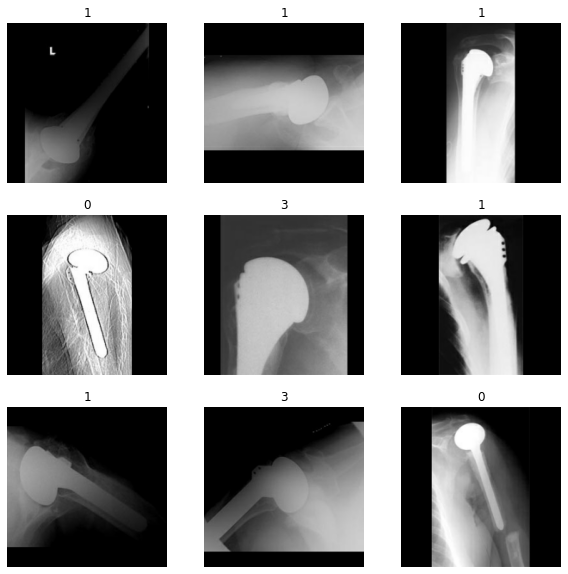

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(np.argmax(labels[i])))
        plt.axis("off")

Data augmentation was applied to improve the generalization of the prediction model.

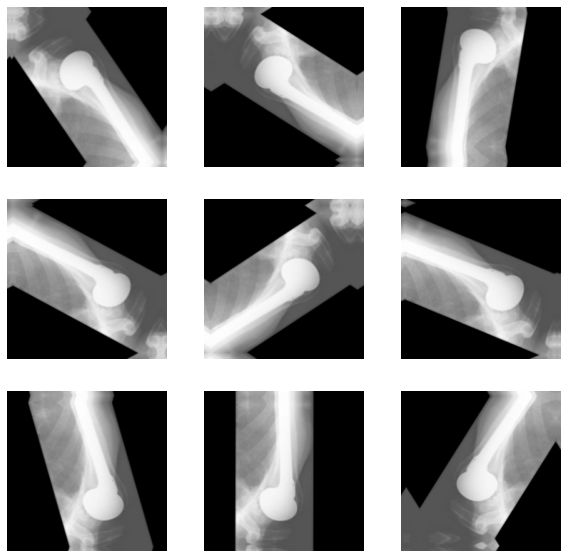

In [ ]:
data_augmentation = keras.Sequential(
    [
        keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        keras.layers.experimental.preprocessing.RandomRotation(0.2),
        keras.layers.experimental.preprocessing.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1)),
        keras.layers.experimental.preprocessing.RandomZoom(height_factor=(0.05, 0.1))
    ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

As the training dataset is limited, transfer learning technique was used: Create the CNN model from MobileNetV2 (with pre-trained weights based on ImageNet dataset). Top layer was replaced by Dense layer with 4 output units (we only have four classes). Dropout was applied for regularization.

In [ ]:
base_model = keras.applications.MobileNetV2(weights='imagenet', include_top=False)

#for i in range(len(base_model.layers)-2):
#  base_model.layers[i].trainable = False
base_model.trainable = False

#base_model.layers[-3].trainable = True
#base_model.layers[-2].trainable = True
#base_model.layers[-1].trainable = True
inputs = keras.Input(shape=(224, 224, 3))

x = data_augmentation(inputs)

x = keras.layers.experimental.preprocessing.Rescaling(1.0 / 127.5, offset=-1)(x)
#x = rescale(x)
#Keep batchnorm layers in inference mode when unfreeze the base model for fine-tuning
x = base_model(x, training=False)
#x = base_model(x)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(.1)(x)
outputs = keras.layers.Dense(4)(x)

model = keras.Model(inputs, outputs)

#model.get_layer('mobilenetv2_1.00_224').layers[-3].trainable = True
#model.get_layer('mobilenetv2_1.00_224').layers[-2].trainable = True 
#model.get_layer('mobilenetv2_1.00_224').layers[-1].trainable = True 
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, None, None, 1280)  2257984   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 5124

Compile and train

In [ ]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=5e-4,
    decay_steps=10000,
    decay_rate=0.9)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule), loss=keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
epochs = 30
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/30
8/8 [==============================] - 37s 4s/step - loss: 1.4663 - accuracy: 0.4258 - val_loss: 1.3981 - val_accuracy: 0.3697
Epoch 2/30
8/8 [==============================] - 33s 4s/step - loss: 1.3046 - accuracy: 0.4523 - val_loss: 1.3810 - val_accuracy: 0.4454
Epoch 3/30
8/8 [==============================] - 32s 4s/step - loss: 1.3155 - accuracy: 0.4909 - val_loss: 1.2850 - val_accuracy: 0.4790
Epoch 4/30
8/8 [==============================] - 32s 4s/step - loss: 1.3009 - accuracy: 0.4337 - val_loss: 1.3039 - val_accuracy: 0.4706
Epoch 5/30
8/8 [==============================] - 32s 4s/step - loss: 1.2232 - accuracy: 0.5110 - val_loss: 1.2679 - val_accuracy: 0.5042
Epoch 6/30
8/8 [==============================] - 33s 4s/step - loss: 1.2670 - accuracy: 0.4844 - val_loss: 1.2503 - val_accuracy: 0.5042
Epoch 7/30
8/8 [==============================] - 33s 4s/step - loss: 1.1635 - accuracy: 0.5393 - val_loss: 1.2058 - val_accuracy: 0.5378
Epoch 8/30
8/8 [==================

The training and validation accuracy were 62% and 58% after 30 epochs. This is about 10% lower than the top-1 accuracy of MobileNetV2 tested on ImageNet dataset. One possible reason could be: our X-ray image dataset is different from ImageNet dataset. Therefore, some discriminative features learned in ImageNet dataset may not be generalizable to X-ray image dataset.

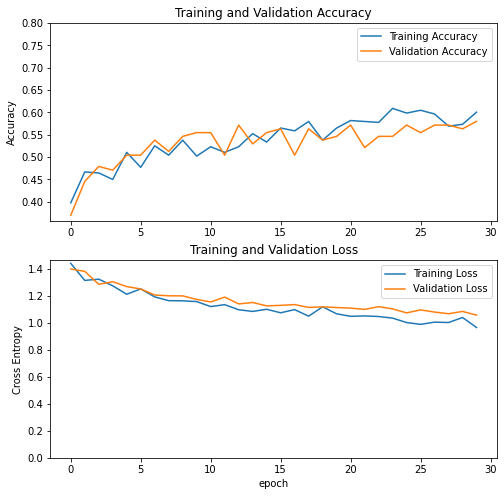

In [ ]:
# accuracy vs epoch and loss vs epoch plots
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),.8])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()